In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

import imblearn
from imblearn.over_sampling import SMOTE

In [52]:
sentinel_1 = pd.read_csv('Sentinel_training_farms_Tuned_s1.csv')
sentinel_2 = pd.read_csv('Sentinel_training_farms_Tuned_s2.csv')

In [53]:
sentinel_1['season'] = 1
sentinel_2['season'] = 2

In [54]:
data = sentinel_1.append(sentinel_2) # concat season1 and season2 data

In [55]:
data.drop(['system:index', '.geo'], axis=1, inplace=True)

In [56]:
y = data['CID']
X = data.drop(['CID'], axis=1)

In [57]:
y.shape, X.shape

((121484,), (121484, 18))

In [58]:
# Upsampling data:
smt = SMOTE(random_state = 123)
X_smote, y_smote = smt.fit_resample(X,y)

In [59]:
X_smote.shape, y_smote.shape

((365544, 18), (365544,))

In [78]:
from collections import Counter
#Counter(y_smote)

## Tests & Tuning:

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y, shuffle=True,random_state=123)
# previously unstratified in *_landsat

In [61]:
hyper_table_rf_tests =[]

estimators = [25, 50, 100, 150, 200, 250, 300, 350, 400]

for estimator in estimators:
    
    hyper_param = {}
    
    rf = RandomForestClassifier(n_estimators = estimator)
    
    #Cross-Validate Using the original data:
        
    xval_scores = cross_val_score(rf, X,y, scoring='f1_weighted', cv=2)
        
    hyper_param['xval_scores'] = xval_scores
    hyper_param  ['model'] = rf.__class__.__name__
    hyper_param['estimator']= estimator
    
    # fit and predict Using Upsampling data (SMOTE)
    rf.fit(X_train, y_train) 
    rf_predict = rf.predict(X_test)
    rf_train_predict = rf.predict(X_train)
    rf_predict_proba = rf.predict_proba(X_test)
    
    # Calculate f1 score (Using SMOTEd data)
    hyper_param['f1score_wghtd'] = f1_score(y_test, rf_predict, average='weighted')
    
    hyper_param['accuracy'] = accuracy_score(y_test, rf_predict)
    #hyper_param['accuracy_train'] = accuracy_score(y_train, rf_train_predict)
    
    # Calculate log loss
    logloss = log_loss(y_test, rf_predict_proba)
    hyper_param['log_loss'] = logloss
    
    hyper_table_rf_tests.append(hyper_param)

In [64]:
hyper_table_rf_tests = pd.DataFrame(hyper_table_rf_tests)
hyper_table_rf_tests

,xval_scores,model,estimator,f1score_wghtd,accuracy,log_loss
0,"[0.3004658065944259, 0.2812765436075838]",RandomForestClassifier,25,0.738133,0.748345,1.321376
1,"[0.3012747252606613, 0.27238468618450207]",RandomForestClassifier,50,0.745457,0.755853,1.007416
2,"[0.3125501379836418, 0.27137314785905514]",RandomForestClassifier,100,0.748451,0.759046,0.839641
3,"[0.31868630708323836, 0.2751072373783711]",RandomForestClassifier,150,0.750344,0.760890,0.806914
4,"[0.3067153662551945, 0.2766764624466463]",RandomForestClassifier,200,0.750646,0.761154,0.794160
5,"[0.3107158485964776, 0.2776553573676503]",RandomForestClassifier,250,0.750508,0.761022,0.777578
6,"[0.31158410173736, 0.2754057667460739]",RandomForestClassifier,300,0.751139,0.761681,0.774161
7,"[0.3095753568488561, 0.27636947888492785]",RandomForestClassifier,350,0.750726,0.761253,0.771080
8,"[0.3139000887766987, 0.2761602293596672]",RandomForestClassifier,400,0.751950,0.762306,0.769184


Text(0, 0.5, 'log_loss score')

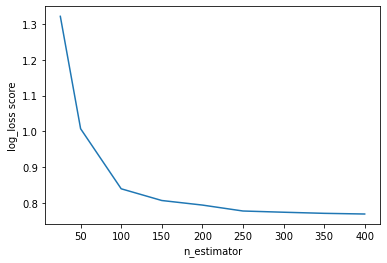

In [65]:
plt.plot(hyper_table_rf_tests['estimator'], hyper_table_rf_tests['log_loss'])
plt.xlabel('n_estimator')
plt.ylabel('log_loss score')
#plt.ylim([1, 3])

#### Xval with upsample data (SMOTE):

Taking care of the imbalanced data resulted in a more generalized solution.

In [67]:
model = RandomForestClassifier(n_estimators=150)
score = {'acc': 'accuracy',
         'prec_macro': 'precision_macro',
         'rec_macro': 'recall_macro',
         'f1_wgtd': 'f1_weighted'}
xval_SMOTE_150 = cross_validate(model, X_smote,y_smote, scoring=score, return_train_score = True,cv=3)
xval_SMOTE_150

{'fit_time': array([164.3512702 , 152.80134249, 149.62682056]),
 'score_time': array([4.67690396, 5.24854851, 5.4583118 ]),
 'test_acc': array([0.84543037, 0.88236984, 0.87907065]),
 'train_acc': array([0.9999959 , 0.99951579, 0.99945834]),
 'test_prec_macro': array([0.8270885 , 0.8763211 , 0.87701515]),
 'train_prec_macro': array([0.9999959 , 0.99951611, 0.99945865]),
 'test_rec_macro': array([0.84543232, 0.88237213, 0.87906629]),
 'train_rec_macro': array([0.9999959 , 0.9995158 , 0.99945834]),
 'test_f1_wgtd': array([0.81954521, 0.87324473, 0.85363999]),
 'train_f1_wgtd': array([0.9999959 , 0.99951579, 0.99945834])}

In [68]:
print('xval_SMOTE_150_f1_weighted, averaged for cv=3 : ',xval_SMOTE_150['test_f1_wgtd'].mean())
print('xval_SMOTE_150_test_acc, averaged : ', xval_SMOTE_150['test_acc'].mean())
print('xval_SMOTE_150_train_acc, averaged : ', xval_SMOTE_150['train_acc'].mean())


xval_SMOTE_150_f1_weighted, averaged for cv=3 :  0.8488099763369381
xval_SMOTE_150_test_acc, averaged :  0.8689569518306962
xval_SMOTE_150_train_acc, averaged :  0.9996566760772985


#### Scaling data using StandardScaler:

Scaling the data still resulted in big difference between train and test accuracies and f1 values.

In [11]:
#xval_scores_StandarsSc_150 = xval_scores
#xval_scores_StandarsSc_150

array([0.47143086, 0.496427  , 0.44170555])

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
model = RandomForestClassifier(n_estimators=150)
score = {'acc': 'accuracy',
         'prec_macro': 'precision_macro',
         'rec_macro': 'recall_macro',
         'f1_wgtd': 'f1_weighted'}
xval_scaled_150 = cross_validate(model, X_scaled,y, scoring=score, return_train_score = True,cv=3)
xval_scaled_150

C:\Users\ssatt\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'fit_time': array([39.26661658, 48.97238326, 45.74046636]),
 'score_time': array([1.27030659, 1.56401896, 1.65357447]),
 'test_acc': array([0.46553896, 0.52836153, 0.49162839]),
 'train_acc': array([0.99918507, 0.99918507, 0.99877763]),
 'test_prec_macro': array([0.4106095 , 0.33712944, 0.29726873]),
 'train_prec_macro': array([0.99853496, 0.99859765, 0.99779736]),
 'test_rec_macro': array([0.30873087, 0.29782614, 0.24826133]),
 'train_rec_macro': array([0.99868696, 0.99862774, 0.99811236]),
 'test_f1_wgtd': array([0.47028486, 0.49608779, 0.44129827]),
 'train_f1_wgtd': array([0.99918509, 0.99918532, 0.99877799])}

## Final model:

In [72]:
from sklearn.pipeline import Pipeline

In [73]:
y = data['CID']
X = data.drop(['CID'], axis=1)

In [74]:
model = RandomForestClassifier(n_estimators=250)

# Modeling code in a pipeline
my_pipeline = Pipeline(steps=[('model', model)])

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=123)

# Scaling training data ONLY:
smt = SMOTE(random_state = 123)
X_train_smote, y_train_smote = smt.fit_resample(X_train,y_train)
X_test_smote, y_test_smote = smt.fit_resample(X_test, y_test)

# fit model on scaled training data:
my_pipeline.fit(X_train_smote, y_train_smote)

# Get predictions
model_preds = my_pipeline.predict(X_test)
model_preds_smote = my_pipeline.predict(X_test_smote)
# Evaluate the model

cr = classification_report(y_test, model_preds, labels = [1,2,3,4,5,6,7,8,9], zero_division=0,
                          target_names=['cotton','dates','grass','alfalfa', 'maize', 'pecan',
                                       'vacant', 'vineyard', 'vineyard+pecan'])
print(f'Classification Report. regular data: \n{cr}')

# creating a confusion matrix 
cm = confusion_matrix(y_test, model_preds) 
print(f'Confustion_Matrix. regular data: \n{cm}')


Classification Report. regular data: 
                precision    recall  f1-score   support

        cotton       0.72      0.79      0.75      2005
         dates       0.36      0.56      0.44        48
         grass       0.53      0.59      0.56      1147
       alfalfa       0.82      0.84      0.83      8015
         maize       0.80      0.76      0.78      4524
         pecan       0.74      0.72      0.73      3157
        vacant       0.68      0.68      0.68      4115
      vineyard       0.82      0.81      0.81     12185
vineyard+pecan       0.54      0.57      0.56      1250

      accuracy                           0.77     36446
     macro avg       0.67      0.70      0.68     36446
  weighted avg       0.77      0.77      0.77     36446

Confustion_Matrix. regular data: 
[[1587    2   22   55   54   73   77  130    5]
 [   2   27    5    1    0    2    4    7    0]
 [  24    5  680  153   47   14   99  118    7]
 [ 130    9  109 6694  204  106  296  417   50]
 [ 11

### Classification report using original data (trained on upsampled data):

In [77]:
print(f'Classification Report. regular data: \n{cr}')

Classification Report. regular data: 
                precision    recall  f1-score   support

        cotton       0.72      0.79      0.75      2005
         dates       0.36      0.56      0.44        48
         grass       0.53      0.59      0.56      1147
       alfalfa       0.82      0.84      0.83      8015
         maize       0.80      0.76      0.78      4524
         pecan       0.74      0.72      0.73      3157
        vacant       0.68      0.68      0.68      4115
      vineyard       0.82      0.81      0.81     12185
vineyard+pecan       0.54      0.57      0.56      1250

      accuracy                           0.77     36446
     macro avg       0.67      0.70      0.68     36446
  weighted avg       0.77      0.77      0.77     36446



### Classification report using Upsampled data (trained on upsampled data):

In [76]:
 print(classification_report(y_test_smote, model_preds_smote, labels = [1,2,3,4,5,6,7,8,9], zero_division=0,
                          target_names=['cotton','dates','grass','alfalfa', 'maize', 'pecan',
                                       'vacant', 'vineyard', 'vineyard+pecan']))

                precision    recall  f1-score   support

        cotton       0.84      0.82      0.83     12185
         dates       0.98      0.60      0.74     12185
         grass       0.70      0.62      0.66     12185
       alfalfa       0.67      0.84      0.74     12185
         maize       0.80      0.77      0.79     12185
         pecan       0.80      0.75      0.77     12185
        vacant       0.64      0.67      0.65     12185
      vineyard       0.52      0.81      0.63     12185
vineyard+pecan       0.86      0.65      0.74     12185

      accuracy                           0.72    109665
     macro avg       0.76      0.72      0.73    109665
  weighted avg       0.76      0.72      0.73    109665

